# 05_epl_tweet_analysis
In addition to the analysis we conducted for the world cup,  we are repeating a similar tweet-level analysis with a focus on URLs for the recent round of premier league fixtures. Specifically, we collected tweets for:
- Liverpool vs Chelsea (21/01/23, 12:30 GMT)
- Arsenal vs Man United (22/01/23, 16:30 GMT)

For both of these games, we got tweets for one our before and after kickoff as well as during the game. 

This analysis will be structured as follows:
- summary-stats - number of tweets, volume by time, comparing the two datasets, etc.
- extracting URLs and expanding them

NL, 23/01/23  
NL, 24/01/23 -- finishing off, with expanded URLs

### IMPORTS

In [40]:
import os
import pandas as pd
import numpy as np
import json
from tqdm import tqdm

### PATHS & CONSTANTS

In [3]:
TWEETS_PATH = '/home/nikloynes/projects/world_cup_misinfo_tracking/data/epl_tweets/'
DAY_1_PATH = TWEETS_PATH+'210123/'
DAY_2_PATH = TWEETS_PATH+'220123/'

In [4]:
EXPORT_PATH = '/home/nikloynes/projects/world_cup_misinfo_tracking/data/exports/epl_tweets/'

### INIT

In [5]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)

### THE THING!

... scroll down to `1. Users` if you aren't interested in the technical thing surrounding data I/O

Sorting out and reading in tweet & URL data... 

In [6]:
tweet_files = os.listdir(DAY_1_PATH)

In [7]:
tweet_files.remove('epl_tweets_2023_01_18-15_43_42.json') # data from testing
tweet_files.remove('meta') # meta dir
tweet_files.remove('epl_tweets_2023_01_18-15_50_01.json') # data from testing

In [8]:
tweet_files = [DAY_1_PATH+x for x in tweet_files]

In [9]:
tmp = os.listdir(DAY_2_PATH)

In [10]:
tmp.remove('meta')

In [11]:
tweet_files += [DAY_2_PATH+x for x in tmp]

In [12]:
tweet_files.sort()

In [13]:
tweet_files

['/home/nikloynes/projects/world_cup_misinfo_tracking/data/epl_tweets/210123/epl_tweets_2023_01_21-11_30_01.json',
 '/home/nikloynes/projects/world_cup_misinfo_tracking/data/epl_tweets/210123/epl_tweets_2023_01_21-12_30_01.json',
 '/home/nikloynes/projects/world_cup_misinfo_tracking/data/epl_tweets/210123/epl_tweets_2023_01_21-13_30_01.json',
 '/home/nikloynes/projects/world_cup_misinfo_tracking/data/epl_tweets/210123/epl_tweets_2023_01_21-14_30_01.json',
 '/home/nikloynes/projects/world_cup_misinfo_tracking/data/epl_tweets/220123/epl_tweets_2023_01_22-15_30_01.json',
 '/home/nikloynes/projects/world_cup_misinfo_tracking/data/epl_tweets/220123/epl_tweets_2023_01_22-16_30_01.json',
 '/home/nikloynes/projects/world_cup_misinfo_tracking/data/epl_tweets/220123/epl_tweets_2023_01_22-17_30_01.json',
 '/home/nikloynes/projects/world_cup_misinfo_tracking/data/epl_tweets/220123/epl_tweets_2023_01_22-18_30_02.json']

Pulling all tweets and all URL-sharing instances into memory

In [14]:
all_tweets = []
all_urls_timestamps = []

for file in tqdm(tweet_files):
    with open(file, 'r') as infile:
        for line in infile:
            
            # tweets
            tmp = json.loads(line)
            if 'domains' in tmp.keys():
                del tmp['domains']
            if 'entities' in tmp.keys():
                del tmp['entities']
            all_tweets.append(tmp)

            # urls
            if 'urls' in tmp.keys():
                for item in tmp['urls']:
                    all_urls_timestamps.append({'url' : item, 'timestamp' : tmp['created_at']})

100%|██████████| 8/8 [00:27<00:00,  3.41s/it]


In [15]:
len(all_tweets)

1141414

In [16]:
all_tweets_df = pd.DataFrame(all_tweets)

In [17]:
all_tweets_df = all_tweets_df.rename(columns={'id' : 'tweet_id'})

In [18]:
all_tweets_df = pd.concat([all_tweets_df.drop(['public_metrics'], axis=1), all_tweets_df['public_metrics'].apply(pd.Series)], axis=1)

In [19]:
all_tweets_df = pd.concat([all_tweets_df.drop(['user'], axis=1), all_tweets_df['user'].apply(pd.Series)], axis=1)

In [20]:
all_tweets_df = all_tweets_df.rename(columns={'id' : 'user_id'})

In [21]:
all_tweets_df = pd.concat([all_tweets_df.drop(['public_metrics'], axis=1), all_tweets_df['public_metrics'].apply(pd.Series)], axis=1)

In [22]:
all_tweets_df = all_tweets_df.rename(columns = {all_tweets_df.columns[1] : 'tweet_created_at', all_tweets_df.columns[11] : 'user_created_at'})    

A total of `1,141,414` tweets were collected over both data collection periods.

Extracting URLs and sending to a separate process for expansion... 

In [23]:
all_urls_timestamps_df = pd.DataFrame(all_urls_timestamps)
len(all_urls_timestamps_df)

542944

In [36]:
len(all_urls_timestamps)/len(all_tweets)*100

47.56766607033031

A total of `542,944` link-sharing incidences in our entire sample, out of a total of `1,141,414` tweets. So, `~47.6%` of tweets contained a URL.

In [24]:
unique_urls_freqs_df = all_urls_timestamps_df.groupby('url').count().reset_index().rename(columns={'timestamp' : 'freq'}).sort_values('freq', ascending=False).reset_index(drop=True)

In [25]:
len(unique_urls_freqs_df)

186024

In [26]:
unique_urls_freqs_df.head()

,url,freq
0,https://t.co/Dw9ltLW7T7,10226
1,https://t.co/1Tbu8SP8p9,5924
2,https://t,5681
3,https://t.co/hnt6oNc0Nw,3202
4,https://t.co/eZnJLPp6B5,2810


We have a total of `186024` unique (shortened) URLs. Let us now export these for expansion... 

In [41]:
# unique_urls_freqs_df.to_csv(EXPORT_PATH+'unique_urls_freqs.csv', index=False)

#### 1. Users

This is what our tweet dataset looks like:

In [27]:
all_tweets_df.head()

,author_id,tweet_created_at,tweet_id,referenced_tweets,text,urls,withheld,retweet_count,reply_count,like_count,quote_count,user_created_at,tweet_created_at,description,user_id,location,name,username,withheld,followers_count,following_count,tweet_count,listed_count
0,1306264256384503810,2023-01-21T11:30:14.000Z,1616760076613685248,"[{'type': 'replied_to', 'id': '161640912456818...",@1cEphraimCFC Lol trash ke?,NaN,NaN,0,0,0,0,0,2020-09-16T16:10:56.000Z,"Rapper,singer, songwriter, Music Therapist, po...",1306264256384503810,Nigeria,PLAYMAKER🎤🎶🖊⚽️💪,POTENTMUSIC01,NaN,143,514,4198,0
1,1313192105439711234,2023-01-21T11:30:14.000Z,1616760076043423745,"[{'type': 'retweeted', 'id': '1616758845757607...",RT @TrollFootball: Liverpool vs Chelsea be lik...,[https://t.co/2NrxYozag2],NaN,191,0,0,0,0,2020-10-05T18:59:41.000Z,,1313192105439711234,NaN,Chriswayne Auffray,ChriswayneAuff1,NaN,1,72,80,0
2,1473100428015513604,2023-01-21T11:30:15.000Z,1616760078434201600,"[{'type': 'quoted', 'id': '1616759107096088576'}]",Klopp Salope t’as chaud ou quoi 😂😂😂🫵🏾 https://...,[https://t.co/aEltVjkUt2],NaN,0,0,0,0,0,2021-12-21T01:18:22.000Z,Live and die for the CFC,1473100428015513604,Stamford Bridge,HØUDINI,kezo_7x,NaN,460,428,8507,0
3,1469337076579643392,2023-01-21T11:30:15.000Z,1616760078782332931,"[{'type': 'retweeted', 'id': '1616759242450472...",RT @the_smallie: This Chelsea Vs Liverpool mat...,NaN,NaN,10,0,0,0,0,2021-12-10T16:04:26.000Z,"Girl, daughter, sister. Till you balance every...",1469337076579643392,"Federal Capital Territory, Nig",Mary Samuel,Mayree_szn,NaN,502,670,2626,0
4,1546112807321600001,2023-01-21T11:30:15.000Z,1616760077574176772,"[{'type': 'replied_to', 'id': '161669937602545...",@FrankKhalidUK All of them,NaN,NaN,0,0,0,0,0,2022-07-10T12:43:32.000Z,,1546112807321600001,NaN,Jeanlouis,Jfx78,NaN,1,45,6,0


In [28]:
all_users_df = all_tweets_df.groupby('author_id').count()[['text']].reset_index().merge(all_tweets_df.groupby('author_id').sum()[['retweet_count', 'reply_count', 'like_count', 'quote_count']].reset_index(), on='author_id', how='left')

/tmp/ipykernel_22243/1048200131.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  all_users_df = all_tweets_df.groupby('author_id').count()[['text']].reset_index().merge(all_tweets_df.groupby('author_id').sum()[['retweet_count', 'reply_count', 'like_count', 'quote_count']].reset_index(), on='author_id', how='left')


In [30]:
all_users_df = all_users_df.rename(columns={'text' : 'n_tweets'})

In [31]:
all_users_df = all_users_df.sort_values('n_tweets', ascending=False).reset_index(drop=True)

In [32]:
all_users_df = all_users_df.rename(columns={'author_id' : 'user_id'})

In [33]:
all_users_df = all_users_df.merge(all_tweets_df[['user_id', 'username', 'name', 'location', 'followers_count', 'following_count', 'tweet_count', 'listed_count']], 
                                  on='user_id',
                                  how='left')

In [34]:
all_users_df = all_users_df.drop_duplicates('user_id').reset_index(drop=True)

In [57]:
print(f'Total number of unique users in dataset: {len(all_users_df)}')
print(f'Mean number of tweets per user: {np.mean(all_users_df["n_tweets"])}')

Total number of unique users in dataset: 457896
Mean number of tweets per user: 2.492736341876758


So, we have a total number `457,896` unique users in our dataset. This means that on average, a given user tweeted `2.49` times in our dataset.

In [36]:
all_users_df[:100]

,user_id,n_tweets,retweet_count,reply_count,like_count,quote_count,username,name,location,followers_count,following_count,tweet_count,listed_count
0,1376767173004296192,734,0,0,0,0,Alihasnain78965,Hasnain Shoukat,Basirpur Pakistan,39,121,40,0
1,1565578355440861186,605,1,0,0,0,Charlot30454242,ONE ALL SPORTS,NaN,1,2,1109,0
2,1581130117153112064,599,0,0,1,0,Mila02451615,Mila,NaN,4,6,1687,0
3,1568228304183869441,598,0,0,0,0,JuliaSw14628318,SKY LIVE SPORTS,NaN,1,6,1264,0
4,985206381128003584,590,0,0,3,0,anityakumar7,anitya kumar mourya,NaN,1,4,977,0
5,1597124775251709954,589,0,0,0,0,ayhytuyui,🔴FUTBOLL🔴,NaN,35,71,2758,0
6,1586404712131313666,585,0,0,0,0,Alina31277243,Алина,NaN,3,2,1212,0
7,1586404734151311360,584,0,0,0,0,Inna45984939,Инна,NaN,1,2,1516,0
8,1597095922051194880,581,0,0,0,0,MaryHam03928499,Mary Hamilton,NaN,1,1,4263,0
9,1569670191080161280,564,0,0,0,0,Mahim41586381,Mahim,NaN,5,5,34561,0


In [46]:
print(f'Mean number of followers, top 100 tweeters by frequency: {np.mean(all_users_df[:100]["followers_count"])}')
print(f'Mean number of followers, all tweeters: {np.mean(all_users_df["followers_count"])}')
print('')
print(f'Median number of followers, top 100 tweeters by frequency: {np.median(all_users_df[:100]["followers_count"])}')
print(f'Median number of followers, all tweeters: {np.median(all_users_df["followers_count"])}')
print('')
print(f'Max number of followers, top 100 tweeters by frequency: {np.max(all_users_df[:100]["followers_count"])}')
print(f'Max number of followers, all tweeters: {np.max(all_users_df["followers_count"])}')

Mean number of followers, top 100 tweeters by frequency: 64.2
Mean number of followers, all tweeters: 4739.131815958209

Median number of followers, top 100 tweeters by frequency: 70.0
Median number of followers, all tweeters: 245.0

Max number of followers, top 100 tweeters by frequency: 169
Max number of followers, all tweeters: 38683542


Histogram of follower distribution for top 100 tweeters by tweet frequency:

<AxesSubplot: >

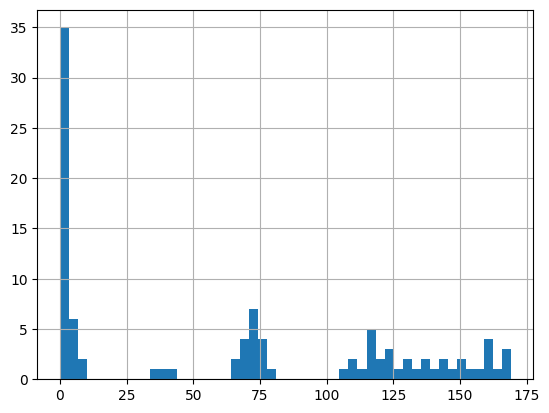

In [47]:
all_users_df[:100]['followers_count'].hist(bins=50)

**Quick takeaways**:
- The users who tweeted most in our samples can't be described as prolific users in any metric besides their tweet frequency. 
- When looking at their usernames and bios/descriptions, it appears that a lot of these users go by arabic names, and/or seem to be impersonating popular sports media
- As previously stated, we shouldn't rely on the interaction numbers for these users, or indeed any users/tweets in our dataset, as we got our tweets via streaming, i.e. directly when they got published. There will have been hardly any time for the tweets to garner any attention and thus interactions.

Let's now have a quick look at our top users in this set, sorted by follower numbers.

In [51]:
all_users_df.sort_values('followers_count', ascending=False).reset_index(drop=True)[:100]

,user_id,n_tweets,retweet_count,reply_count,like_count,quote_count,username,name,location,followers_count,following_count,tweet_count,listed_count
0,343627165,21,198,0,7,0,premierleague,Premier League,NaN,38683542,82,145015,33797
1,558797310,21,4,3,14,0,ManUtd,Manchester United,"Old Trafford, Manchester",34709775,169,79116,26808
2,19426551,1,0,0,0,0,NFL,NFL,NaN,32477263,2791,250934,51885
3,5988062,1,0,0,0,0,TheEconomist,The Economist,London,27175042,151,331352,122121
4,1652541,2,0,0,0,0,Reuters,Reuters,Around the world,25716149,1234,964021,136213
5,22910295,12,0,0,24,0,ChelseaFC,Chelsea FC,"London, England",23841065,304,112464,27166
6,19583545,29,3,6,31,0,LFC,Liverpool FC,Anfield,23261096,356482,107452,28429
7,34613288,13,16,1,84,0,Arsenal,Arsenal,London,21087392,145226,102606,32468
8,69183155,5,0,0,0,0,detikcom,detikcom,"Jakarta, Indonesia",19842621,35,2160140,13291
9,37034483,1,1,0,0,0,ndtv,NDTV,India,17684661,15,1074732,14568


No big surprises there -- these are pretty much the accounts we'd expect; associated with the clubs/league themselves, as well as media and prominent personalities within the game. 

One slight surprise is the `NFL` account in there... let's have a quick look at their tweets just for fun...

In [55]:
all_tweets_df.loc[all_tweets_df['author_id']=='19426551']

,author_id,tweet_created_at,tweet_id,referenced_tweets,text,urls,withheld,retweet_count,reply_count,like_count,quote_count,user_created_at,tweet_created_at,description,user_id,location,name,username,withheld,followers_count,following_count,tweet_count,listed_count
548586,19426551,2023-01-22T15:55:00.000Z,1617189092562800640,NaN,Who will move on to the AFC Championship? 👀\n\...,"[https://t.co/fK7vaWiHIa, https://t.co/kLxDcbj...",NaN,0,0,0,0,0,2009-01-24T01:28:06.000Z,It's time for the #NFLPlayoffs.,19426551,NaN,NFL,NFL,NaN,32477263,2791,250934,51885


Right, so they weren't tweeting about *football*, just about "football". 

#### 2. (popular) tweets

We will now have a look at tweets which are **referenced** by other tweets. This can be a (quote) retweet or a reply. This is kind a heuristic we can employ to see which tweets were most popular in our period of data collection which doesn't rely on interaction numbers for the tweets we've already collected (as previously mentioned, these are not reliable). 

What we will do is the following:
- iterate through all tweets we've collected
- tally up the number of times a given tweet id appears in the `referenced_tweet` column
- pull the tweets for the top 1000 tweets from this category (as we won't have already collected all of them - many may predate our data collection window.)

In [61]:
top_referenced_tweets = {}
for tweet in all_tweets:
    if 'referenced_tweets' in tweet.keys():
        for ref in tweet['referenced_tweets']:
            if ref['id'] not in top_referenced_tweets.keys():
                top_referenced_tweets[ref['id']] = 1
            else:
                top_referenced_tweets[ref['id']] += 1

In [63]:
len(top_referenced_tweets)

159194

We have found a total of `159,194` tweets which were referenced by other tweets in our dataset.

In [64]:
top_referenced_tweets = dict(sorted(top_referenced_tweets.items(), key=lambda x:x[1], reverse=True))

In [69]:
target_tweet_ids = list(top_referenced_tweets.keys())[:1000]

Let's write these tweet ids out so we can collect them... 

In [71]:
with open(EXPORT_PATH+'top_epl_referenced_tweet_ids.txt', 'w') as outfile:
    for line in target_tweet_ids:
        outfile.write(line+'\n')

We've pulled the full tweet objects for these using the script `data_collection/get_tweets_by_id.py`. 

In [94]:
TOP_REFERENCED_TWEETS_JSON = EXPORT_PATH+'top_epl_referenced_tweets.json'

In [99]:
referenced_tweets = []
ref_tweets_all_urls = []

with open(TOP_REFERENCED_TWEETS_JSON, 'r') as infile:
    for line in infile:
        
        # tweets
        tmp = json.loads(line)
        if 'domains' in tmp.keys():
            del tmp['domains']
        if 'entities' in tmp.keys():
            del tmp['entities']
        referenced_tweets.append(tmp)

        # urls
        if 'urls' in tmp.keys():
            for item in tmp['urls']:
                ref_tweets_all_urls.append({'url' : item, 'timestamp' : tmp['created_at']})

In [101]:
referenced_tweets_df = pd.DataFrame(referenced_tweets)

In [102]:
referenced_tweets_df = referenced_tweets_df.rename(columns={'id' : 'tweet_id'})
referenced_tweets_df = pd.concat([referenced_tweets_df.drop(['public_metrics'], axis=1), referenced_tweets_df['public_metrics'].apply(pd.Series)], axis=1)
referenced_tweets_df = pd.concat([referenced_tweets_df.drop(['user'], axis=1), referenced_tweets_df['user'].apply(pd.Series)], axis=1)
referenced_tweets_df = referenced_tweets_df.rename(columns={'id' : 'user_id'})
referenced_tweets_df = pd.concat([referenced_tweets_df.drop(['public_metrics'], axis=1), referenced_tweets_df['public_metrics'].apply(pd.Series)], axis=1)
referenced_tweets_df = referenced_tweets_df.rename(columns = {referenced_tweets_df.columns[1] : 'tweet_created_at', referenced_tweets_df.columns[11] : 'user_created_at'})


**Below are our the top 100 referenced tweets from our original dataset**

In [104]:
referenced_tweets_df[:100]

,author_id,user_created_at,tweet_id,text,urls,referenced_tweets,retweet_count,reply_count,like_count,quote_count,impression_count,user_created_at,description,user_id,location,name,username,followers_count,following_count,tweet_count,listed_count
0,3623253454,2023-01-22T18:50:56.000Z,1617233367216578560,Your defence is in trouble!!! 🎶📞 #GodsPlan @Ar...,[https://t.co/Dw9ltLW7T7],NaN,46397,6998,308671,4605,15355255,2015-09-11T18:56:16.000Z,Footballer for @Arsenal,3623253454,"London, England",Eddie Nketiah 📞,EddieNketiah9,561494,280,1314,1149
1,22910295,2023-01-21T11:30:20.000Z,1616760099606827009,Your Chelsea this lunchtime! 👌\n\n@ParimatchGl...,[https://t.co/hnt6oNc0Nw],NaN,3747,2741,22794,3994,5178377,2009-03-05T11:54:25.000Z,,22910295,"London, England",Chelsea FC,ChelseaFC,23870085,304,112509,27190
2,34613288,2023-01-22T18:26:16.000Z,1617227162385260545,BIG. THREE. POINTS. https://t.co/1Tbu8SP8p9,[https://t.co/1Tbu8SP8p9],NaN,34230,4157,143369,8318,6474776,2009-04-23T13:38:19.000Z,The official account of Arsenal Football Club.,34613288,London,Arsenal,Arsenal,21114733,145210,102648,32499
3,34613288,2023-01-22T15:30:35.000Z,1617182948003921921,🔴 𝗧𝗘𝗔𝗠𝙉𝙀𝙒𝙎 ⚪️\n\n🧱 Gabriel at the back\n🪄 Odeg...,[https://t.co/OjJqnWU9W9],NaN,7144,1648,36037,3286,3392004,2009-04-23T13:38:19.000Z,The official account of Arsenal Football Club.,34613288,London,Arsenal,Arsenal,21114733,145210,102648,32499
4,19583545,2023-01-21T11:30:09.000Z,1616760054618771456,Team news 📋\n\nYour #LIVCHE line-up 🔴,NaN,NaN,2499,1062,13123,2901,2886015,2009-01-27T09:05:21.000Z,Official Twitter account of Liverpool Football...,19583545,Anfield,Liverpool FC,LFC,23275374,356453,107495,28446
5,558797310,2023-01-22T15:30:03.000Z,1617182813253500929,🚨 TEAM NEWS 🚨\n\nErik makes one change from We...,NaN,NaN,3993,1168,15520,2494,2257509,2012-04-20T15:17:43.000Z,The home of Manchester United.,558797310,"Old Trafford, Manchester",Manchester United,ManUtd,34736097,170,79175,26821
6,34613288,2023-01-22T18:20:39.000Z,1617225746770006019,YOUR DEFENCE IS IN TROUBLE 🎶\n\nTWO FOR EDDIE ...,[https://t.co/eZnJLPp6B5],NaN,14865,1294,82601,2198,2805213,2009-04-23T13:38:19.000Z,The official account of Arsenal Football Club.,34613288,London,Arsenal,Arsenal,21114733,145210,102648,32499
7,4714743812,2023-01-21T11:52:44.000Z,1616765737087160320,ขอบคุณทุกคนมากๆนะครับที่โหวตให้ผม วันนี้มีโอกา...,[https://t.co/e8yevR7GlQ],NaN,4755,605,18484,179,309457,2016-01-05T18:11:47.000Z,,4714743812,Thailand,ซาลาเปา,Prem_space,1010091,82,3528,971
8,1038874580956442625,2023-01-22T19:21:24.000Z,1617241037428195328,What a WIN! 🔴\nWe never stopped believing. Tha...,[https://t.co/TR1jFsQw3c],NaN,23446,3936,185338,1591,4234661,2018-09-09T19:39:36.000Z,Footballer for @Arsenal.,1038874580956442625,"London, England",Bukayo Saka,BukayoSaka87,1062151,0,205,1140
9,18091004,2023-01-22T15:24:10.000Z,1617181335000424449,Erling Haaland already has more career Premier...,[https://t.co/HlyutEWJr3],NaN,4856,1267,52456,620,3412223,2008-12-13T01:33:04.000Z,All things football. All the time.,18091004,NaN,ESPN FC,ESPNFC,7959701,614,153119,13979


No obvious crypto or illegal streaming stuff in there.

#### 3. URLs

Let's finally get to URLs. We have expanded our `186,024` unique URLs overnight, so can now analyse them.

In [155]:
with open(EXPORT_PATH+'tmp_expanded.json', 'r') as infile:
    expanded_urls = [json.loads(x) for x in infile] 

In [156]:
expanded_urls_df = pd.DataFrame(expanded_urls)

Top domains:

In [157]:
top_domains_df = expanded_urls_df.groupby('resolved_domain').count().reset_index().rename(columns={'resolved_url' : 'freq'})[['resolved_domain', 'freq']].sort_values('freq', ascending=False).reset_index(drop=True)

In [158]:
# let's assign internal/external to the domains... 
top_domains_df.loc[top_domains_df['resolved_domain'].isin(['twitter.com', 't.co', 't', 't.', 't.c']), 'internal'] = True
top_domains_df['internal'].fillna(False, inplace=True) 

In [159]:
streaming = ['blogspot.com', 'jobsnum.com', 'clickhere-sport.com', 'flash-streams.net', '247football.tv', 'lvfoot.co', 'wordpress.com', 'manunitedlivestream.com', 'ukfootball.live',
             'blogger.com', 'fun4all.live', 'ajsportstv.ch', 'shoot2score.live',  ]
crypto_nft = ['booth.pm', 'opensea.io']

In [160]:
top_domains_df.loc[top_domains_df['resolved_domain'].isin(streaming), 'is_streaming'] = True
top_domains_df['is_streaming'].fillna(False, inplace=True)

top_domains_df.loc[top_domains_df['resolved_domain'].isin(crypto_nft), 'is_crypto_nft'] = True
top_domains_df['is_crypto_nft'].fillna(False, inplace=True)

In [161]:
top_domains_df[:100]

,resolved_domain,freq,internal,is_streaming,is_crypto_nft
0,twitter.com,157275,True,False,False
1,blogspot.com,2470,False,True,False
2,whatsapp.com,1651,False,False,False
3,t.co,1311,True,False,False
4,youtube.com,1150,False,False,False
5,linliv.ee,517,False,False,False
6,t.me,468,False,False,False
7,google.com,307,False,False,False
8,apple.com,292,False,False,False
9,joaosilas.net,271,False,False,False


OK -- so we've again included `blogspot.com` as a streaming domain. We obviously can't be 100% confident about this, as there may be completely benign sites shared on this page, but given our experience at the world cup, it's fair to assume that a big majority of them are. We did the same with wordpress. Otherwise, I manually entered all domains in the top 200 by checking them through a browser to find ones which were links to streaming sites. 

Let's now merge these data back into our URL overview table to see what's what. 

In [162]:
expanded_urls_df = expanded_urls_df.merge(top_domains_df, on='resolved_domain', how='left')

In [163]:
len(expanded_urls_df.loc[expanded_urls_df['internal']==False])/len(expanded_urls_df)*100

14.722883921513802

In [164]:
unique_urls_freqs_df = unique_urls_freqs_df.rename(columns={'url' : 'original_url', 'freq' : 'url_freq'})
expanded_urls_df = expanded_urls_df.rename(columns={'freq' : 'domain_freq'})

In [165]:
expanded_urls_df = expanded_urls_df.merge(unique_urls_freqs_df, on='original_url', how='left')

Let's have a quick look at the most common external URLs.

In [168]:
expanded_urls_df.loc[expanded_urls_df['internal']==False].sort_values('url_freq', ascending=False)[:100].reset_index(drop=True)

,original_url,resolved_domain,resolved_url,domain_freq,internal,is_streaming,is_crypto_nft,url_freq
0,https://t.co/RSqq798mzO,blogspot.com,https://sharalsportsofficalllive.blogspot.com/...,2470,False,True,False,900
1,https://t.co/nqwX154Y7M,blogspot.com,https://sete4ry67t57y.blogspot.com/2023/01/ars...,2470,False,True,False,892
2,https://t.co/UMcfkEmeE0,blogspot.com,https://somrat6.blogspot.com/2023/01/liverpool...,2470,False,True,False,891
3,https://t.co/juVO0p4MID,blogspot.com,https://azmira111s.blogspot.com/2023/01/liverp...,2470,False,True,False,890
4,https://t.co/ft2REyNchW,blogspot.com,https://somrat6.blogspot.com/2023/01/liverpool...,2470,False,True,False,884
5,https://t.co/zjt0H1ih4X,blogspot.com,https://sharalsportsofficalllive.blogspot.com/...,2470,False,True,False,879
6,https://t.co/41cbXybIvX,blogspot.com,https://somrat6.blogspot.com/2023/01/liverpool...,2470,False,True,False,870
7,https://t.co/mK3FBUNpIc,blogspot.com,https://sete4ry67t57y.blogspot.com/2023/01/ars...,2470,False,True,False,844
8,https://t.co/Vmq57H43hJ,blogspot.com,https://esrafel115.blogspot.com/2023/01/arsena...,2470,False,True,False,828
9,https://t.co/SJrcgiTV95,blogspot.com,https://somrat7.blogspot.com/2023/01/arsenal-v...,2470,False,True,False,753


OK, so looking at the TOP URLs shared which were not to an internal resource we find: 
- it seems pretty clear that the blogspot URLs are in fact linking to streams. 
- We find that **98 out of 100** uniqe non-internal URLs shared on Twitter are linking to streaming sites.
- This is quite an overwhelming finding, which is in line with what we observed during our world cup data collection.
- We aren't seeing any traffic in our top-100 non-internal URLs to crypto/nft sites.  

Let us now merge this back into *overall* URL sharing patterns. What we're looking at above is unique URLs.

In [171]:
all_urls_timestamps_df = all_urls_timestamps_df.rename(columns={'url' : 'original_url'})

In [173]:
all_urls_timestamps_df = all_urls_timestamps_df.merge(expanded_urls_df, on='original_url', how='left')

In [176]:
len(all_urls_timestamps_df.loc[all_urls_timestamps_df['is_streaming']==True])

129085

In [177]:
len(all_urls_timestamps_df.loc[all_urls_timestamps_df['is_streaming']==True])/len(all_tweets_df)*100

11.309218215301371

In [178]:
len(all_urls_timestamps_df.loc[all_urls_timestamps_df['is_streaming']==True])/len(all_urls_timestamps_df.loc[all_urls_timestamps_df['internal']==False])*100

66.58396434687519

In [179]:
len(all_urls_timestamps_df.loc[all_urls_timestamps_df['is_streaming']==True])/len(all_urls_timestamps_df)*100

23.775011787587673

So, we find a total of `129,085` incidences of posting a tweet to a streaming site.  
This represents `~11.3%` of all tweets posted in the time we collected data.  
This represents `~66.6%` of all link-sharing incidences with links LEAVING twitter.  
This represents `~23.8%` of all links-sharing incidences in our dataset.



#### EXPORTS

In [181]:
all_urls_timestamps_df.to_csv(EXPORT_PATH+'all_urls_timestamps.csv', index=False)
top_domains_df.to_csv(EXPORT_PATH+'top_domains.csv', index=False)
all_users_df.to_csv(EXPORT_PATH+'all_users.csv', index=False)